# Processing Koike-Yusa 2014
- Processing genomewide screen from [Koike-Yusa](https://www.nature.com/articles/nbt.2800)
- Library design: To avoid off-target cleavages, only gRNAs that matched stringent conditions were chosen: from position 8, the 5′-N14GG-3′ of each gRNA only had a single match to the mouse genome. A total of 325,638 sites was identified... Filtering was performed as follows: First, sites with more than 1 perfect hit in any of the Ensembl exons were removed. Second, off-target sites of each candidate gRNA were examined with the following two options (i) N12NGG without any mismatches and (ii) N20NGG with up to three mismatches. Third, gRNAs that are positioned at least 100 bp away from the translation initiation site and in the first half of coding sequences were collected. Finally, up to 5 gRNAs were chosen for each gene, prioritizing gRNAs with fewer predicted off-target sites.

### Data Filters
1. pdna or etp > mean pdna -3 std
2. sgRNAs targetting essential genes
3. Match bin 1, tier 1 score of 0

In [1]:
import pandas as pd
import gpplot
import seaborn as sns
import matplotlib.pyplot as plt
from poola import core as pool

In [2]:
annotations = pd.read_csv('../data/raw/Koike-Yusa2014_library_annotations.csv')
reads = pd.read_csv('../data/raw/Koike-Yusa2014_reads.csv')
essential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/mouse/mouse_essentials.txt',
                                names=['gene'])
nonessential_genes = pd.read_table('https://raw.githubusercontent.com/gpp-rnd/genesets/master/mouse/mouse_non-essentials.txt',
                                    names=['gene'])

In [3]:
clean_reads = (reads.dropna()
               .rename({'Unnamed: 0': 'id', 
                        'ESC1 (normalized)': 'ESC_1', 
                        'ESC2 (normalized)': 'ESC_2'}, axis=1)
               .copy())
clean_reads[['transcript', 'Gene', 'exon', 'exon_#', 'target']] = clean_reads['id'].str.split('_', expand=True)
clean_reads[['chr_#', 'range', 'Strand']] = clean_reads.target.str.split(':', expand=True)
clean_reads['End'] = (clean_reads['range'].str.split('-', expand=True)[1]
                      .astype('int'))
clean_reads['Chr'] = 'chr' + clean_reads['chr_#']
clean_reads = clean_reads[['id', 'Lentiviral Plasmid', 'ESC_1', 'ESC_2', 'Gene', 'Chr', 'End', 'Strand']]

In [4]:
lognorms = pool.lognorm_columns(reads_df=clean_reads, columns=['Lentiviral Plasmid', 'ESC_1', 'ESC_2'])
filtered_lognorms = pool.filter_pdna(lognorm_df=lognorms, pdna_cols=['Lentiviral Plasmid'])
filtered_lognorms.shape[0] - lognorms.shape[0]

0

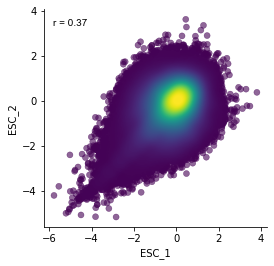

In [5]:
lfc_df = pool.calculate_lfcs(lognorm_df=filtered_lognorms, ref_col='Lentiviral Plasmid', 
                             target_cols=['ESC_1', 'ESC_2'])
plt.subplots(figsize=(4,4))
gpplot.point_densityplot(lfc_df, x = 'ESC_1', y = 'ESC_2')
gpplot.add_correlation(lfc_df, x = 'ESC_1', y = 'ESC_2')
sns.despine()

Note that Sept and March genes are missing annotations

In [6]:
annotated_lfcs = lfc_df.merge(annotations, how='inner', on=['Gene', 'Chr', 'End', 'Strand'])
print(lfc_df.shape[0] - annotated_lfcs.shape[0]) # sept and march genes are missing
print((annotated_lfcs['Target site sequence'].str[1:] != annotated_lfcs['gRNA sequence']).sum())

113
0


In [7]:
avg_replicate_lfc_df = pool.average_replicate_lfcs(lfcs=annotated_lfcs, guide_col='Target site sequence', 
                                                   condition_indices=[0], lfc_cols=['ESC_1', 'ESC_2'], sep='_')

In [8]:
sg_list = list(annotated_lfcs['Target site sequence'].unique())
design_df = pd.read_parquet('/Volumes/GoogleDrive/Shared drives/GPP Cloud /R&D/People/Peter/gpp-annotation-files/sgRNA_design_10090_GRCm38_SpyoCas9_CRISPRko_Ensembl_20200406.parquet',
                            filters=[[('sgRNA Sequence', 'in', sg_list)]])

In [9]:
lfcs_designs = pool.annotate_guide_lfcs(avg_replicate_lfc_df.rename({'Target site sequence': 'sgRNA Sequence'}, axis=1),
                                        design_df, 'Target Gene Symbol', merge_on='sgRNA Sequence')
roc_aucs, _ = pool.get_roc_aucs(lfcs=lfcs_designs, tp_genes=essential_genes.gene,
                                fp_genes=nonessential_genes.gene, gene_col='Target Gene Symbol',
                                condition_col='condition', score_col='avg_lfc')
roc_aucs

,condition,ROC-AUC
0,ESC,0.763577


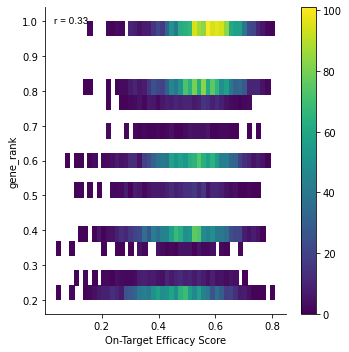

In [10]:
ess_lfcs = lfcs_designs[lfcs_designs['Target Gene Symbol'].isin(essential_genes.gene)]
filtered_sgs = ess_lfcs[(ess_lfcs['# Off-Target Tier I Match Bin I Matches'] == '0')].copy()
filtered_sgs['gene_rank'] = (filtered_sgs.groupby(['Target Gene Symbol'])
                             .avg_lfc
                             .rank(pct=True, ascending=False))
filtered_sgs = filtered_sgs[['sgRNA Sequence', 'sgRNA Context Sequence', 'Target Gene Symbol', 
                             'Target Cut %', 'On-Target Efficacy Score', 'gene_rank']]
sns.displot(filtered_sgs, x = 'On-Target Efficacy Score', y = 'gene_rank', cbar=True, cmap='viridis')
gpplot.add_correlation(filtered_sgs, x='On-Target Efficacy Score', y='gene_rank', method='pearson')
sns.despine()

## Output

In [11]:
output_df = filtered_sgs.drop('On-Target Efficacy Score', axis=1)
output_df

,sgRNA Sequence,sgRNA Context Sequence,Target Gene Symbol,Target Cut %,gene_rank
4,AAAAAACTTGTCTACGGAAA,CCAGAAAAAACTTGTCTACGGAAAAGGGAT,Ythdc1,18.5,1.000000
26,AAAAACAGAACACCGAACAT,CCTTAAAAACAGAACACCGAACATCGGCTG,Ncapg2,38.1,1.000000
34,AAAAACGGTCTCAAGCCAAT,GATGAAAAACGGTCTCAAGCCAATGGGGCA,Parn,24.5,0.500000
37,AAAAACTTACGCAACTCCAT,GGACAAAAACTTACGCAACTCCATGGGGAG,Usp7,18.3,0.400000
38,AAAAACTTCTCGTTCCAGAG,GGTTAAAAACTTCTCGTTCCAGAGGGGTTC,Utp14b,26.4,0.800000
...,...,...,...,...,...
87805,TTTTTGCCACTCGTGAAATC,AACATTTTTGCCACTCGTGAAATCTGGTCT,Etf1,10.2,0.200000
87818,TTTTTTAACGGTCCTGGTTT,TGTTTTTTTTAACGGTCCTGGTTTGGGTCC,Ckap5,26.5,0.200000
87832,TTTTTTTAACCCAGGTTGAT,TTTTTTTTTTTAACCCAGGTTGATAGGACC,Rps21,46.4,0.333333
87834,TTTTTTTGGAAAGTCACGTT,AAGATTTTTTTGGAAAGTCACGTTCGGCAT,Cul2,9.1,0.200000


In [12]:
output_df.to_csv('../data/processed/Koike-Yusa2014_activity.csv', index=False)